# TSPを使用したALNSの実験(Greedy)

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](http://colab.research.google.com/github/magolors/alns_experiment_for_tsp/blob/main/alns_experiment_for_greedy_tsp.ipynb)

このノートの内容は、以下の内容をもとに作成させていただきました。

---
[ALNS - Examples - The travelling salesman problem](https://github.com/N-Wouda/ALNS/blob/master/examples/travelling_salesman_problem.ipynb)

The MIT License (MIT)

Copyright (c) 2019 Niels Wouda

Permission is hereby granted, free of charge, to any person obtaining a copy of this software and associated documentation files (the "Software"), to deal in the Software without restriction, including without limitation the rights to use, copy, modify, merge, publish, distribute, sublicense, and/or sell copies of the Software, and to permit persons to whom the Software is furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY, FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE SOFTWARE.

---

[Google OR-Tools - Routing - Traveling Salesperson Problem](https://developers.google.com/optimization/routing/tsp)

Copyright 2021 Google

Licensed under the Apache License, Version 2.0 (the “License”);
you may not use this file except in compliance with the License.
You may obtain a copy of the License at
http://www.apache.org/licenses/LICENSE-2.0

Unless required by applicable law or agreed to in writing, software
distributed under the License is distributed on an “AS IS” BASIS,
WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.

See the License for the specific language governing permissions and
limitations under the License.

---



## ライブラリのインストール・インポート

pipを使って、ライブラリをインストールする。

In [34]:
!pip install alns tsplib95 ortools
!apt-get update && apt-get install ffmpeg

Ign:1 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Hit:2 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease
Ign:3 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:4 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease
Hit:5 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release
Hit:6 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Hit:7 http://security.ubuntu.com/ubuntu bionic-security InRelease
Hit:8 http://archive.ubuntu.com/ubuntu bionic InRelease
Hit:9 http://ppa.launchpad.net/cran/libgit2/ubuntu bionic InRelease
Hit:10 http://archive.ubuntu.com/ubuntu bionic-updates InRelease
Hit:11 http://archive.ubuntu.com/ubuntu bionic-backports InRelease
Hit:12 http://ppa.launchpad.net/deadsnakes/ppa/ubuntu bionic InRelease
Hit:13 http://ppa.launchpad.net/graphics-drivers/ppa/ubuntu bionic 

In [35]:
import copy
import itertools
import math
from time import time
import random

import numpy as np
import networkx as nx
from alns import ALNS, State
from alns.criteria import HillClimbing, SimulatedAnnealing, AcceptanceCriterion
from alns.Statistics import Statistics
from alns.Result import Result
from alns.select_operator import select_operator
from alns.tools.warnings import OverwriteWarning
import tsplib95
from tsplib95 import distances
import matplotlib.pyplot as plt
from matplotlib import animation, rc
from ortools.constraint_solver import routing_enums_pb2, pywrapcp
from tqdm import tqdm

%matplotlib inline

# The travelling salesman problem

The travelling salesman problem (TSP) is a classic problem in operations research. It asks how to construct the minimum distance tour between a number of cities, such that each city is visited once and the tour concludes at the starting city (that is, it forms a cycle). It is perhaps the best-known problem in the class of [NP-hard](https://en.wikipedia.org/wiki/NP-hardness) problems.



## 要約：巡回セールスマン問題の読み込み



2次元平面にランダムに点を生成し、TSPのデータ形式にしてtsplib95を使って読み込む。

In [36]:
dimension = 100 # 点を dimension 個生成する
max_coord = 100 # [0, max_coord)^2 の領域に点を生成する
seed = 42 # ランダムシード
random.seed(seed)
data_name = f'random_{dimension}_{max_coord}_{seed}'

with open(f'{data_name}.tsp', 'w') as f:
    print(f'NAME : {data_name}', file=f)
    print(f'TYPE : TSP', file=f)
    print(f'DIMENSION : {dimension}', file=f)
    print(f'EDGE_WEIGHT_TYPE : EUC_2D', file=f)
    print(f'NODE_COORD_SECTION', file=f)

    nodes = set()
    for i in range(dimension):
        while True:
            node = (random.randint(0, max_coord), random.randint(0, max_coord))
            if node not in nodes:
                nodes.add(node)
                print(f'{i+1} {node[0]} {node[1]}', file=f)
                break

    print(f'EOF', file=f)


'''
if dataset == 'VLSI':
    data_name_list = ['xqf131', 'xqg237', 'pma343', 'pka379', 'bcl380', 'pbl395', 'pbk411', 'pbn423', 'pbm436', 'xql662', 'rbx711', 'rbu737', 'dkg813', 'lim963', 'pbd984', 'xit1083']

    data_name = data_name_list[1]
    tsp_file = f'https://www.math.uwaterloo.ca/tsp/vlsi/{data_name}.tsp'
    tour_file = f'https://www.math.uwaterloo.ca/tsp/vlsi/{data_name}.tour'

    !wget $tsp_file
    !wget $tour_file

    tour_file_rename_before = f'{data_name}.tour'
    tour_file_rename_after = f'{data_name}.opt.tour'
    !mv $tour_file_rename_before $tour_file_rename_after

elif dataset == 'TSPLIB':
    data_name_list = ['att48', 'ch130']

    data_name = data_name_list[1]
    tsp_file = f'http://comopt.ifi.uni-heidelberg.de/software/TSPLIB95/tsp/{data_name}.tsp.gz'
    tour_file = f'http://comopt.ifi.uni-heidelberg.de/software/TSPLIB95/tsp/{data_name}.opt.tour.gz'

    !wget $tsp_file
    !wget $tour_file

    tsp_file_name = f'{data_name}.tsp.gz'
    tour_file_name = f'{data_name}.opt.tour.gz'

    !gunzip $tsp_file_name $tour_file_name
'''

"\nif dataset == 'VLSI':\n    data_name_list = ['xqf131', 'xqg237', 'pma343', 'pka379', 'bcl380', 'pbl395', 'pbk411', 'pbn423', 'pbm436', 'xql662', 'rbx711', 'rbu737', 'dkg813', 'lim963', 'pbd984', 'xit1083']\n\n    data_name = data_name_list[1]\n    tsp_file = f'https://www.math.uwaterloo.ca/tsp/vlsi/{data_name}.tsp'\n    tour_file = f'https://www.math.uwaterloo.ca/tsp/vlsi/{data_name}.tour'\n\n    !wget $tsp_file\n    !wget $tour_file\n\n    tour_file_rename_before = f'{data_name}.tour'\n    tour_file_rename_after = f'{data_name}.opt.tour'\n    !mv $tour_file_rename_before $tour_file_rename_after\n\nelif dataset == 'TSPLIB':\n    data_name_list = ['att48', 'ch130']\n\n    data_name = data_name_list[1]\n    tsp_file = f'http://comopt.ifi.uni-heidelberg.de/software/TSPLIB95/tsp/{data_name}.tsp.gz'\n    tour_file = f'http://comopt.ifi.uni-heidelberg.de/software/TSPLIB95/tsp/{data_name}.opt.tour.gz'\n\n    !wget $tsp_file\n    !wget $tour_file\n\n    tsp_file_name = f'{data_name}.tsp.gz'

In [37]:
data = tsplib95.load(f'{data_name}.tsp')

# These we will use in our representation of a TSP problem: a list of
# (city, coord)-tuples.
cities = [(city, tuple(coord)) for city, coord in data.node_coords.items()]

In [38]:
def draw_graph(graph, only_nodes=False):
    """
    Helper method for drawing TSP (tour) graphs.
    """
    fig, ax = plt.subplots(figsize=(12, 6))

    if only_nodes:
        nx.draw_networkx_nodes(graph, data.node_coords, node_size=25, ax=ax)
    else:
        nx.draw_networkx(graph, data.node_coords, node_size=25, with_labels=False, ax=ax)

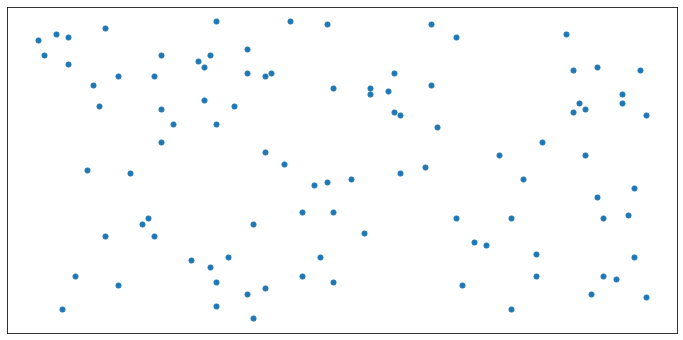

In [39]:
draw_graph(data.get_graph(), True)

# Operators and solution state

To use the ALNS meta-heuristic, we need to have destroy and repair operators that work on a proposed solution, and a way to describe such a solution in the first place. The ALNS package exposes the class ``State`` to describe a solution, with an ``objective()`` member that computes this solution's objective value. Using it, we may compute a simple initial solution, and then apply the ALNS algorithm.

## 要約：Solution state クラスとオペレータを定義する。

Solution state クラスを使用することで、`objective`メソッドにより簡単に目的関数を計算できる。また、ALNSで必要な破壊・復元オペレータを登録する。

## Solution state

In [40]:
class TspState(State):
    """
    Solution class for the TSP problem. It has two data members, nodes, and edges.
    nodes is a list of node tuples: (id, coords). The edges data member, then, is
    a mapping from each node to their only outgoing node.
    """

    def __init__(self, nodes, edges):
        self.nodes = nodes
        self.edges = edges

    def copy(self):
        return copy.deepcopy(self)

    def objective(self):
        """
        The objective function is simply the sum of all individual edge lengths,
        using the rounded Euclidean norm.
        """
        return sum(distances.euclidean(node[1], self.edges[node][1])
                   for node in self.nodes)
    
    def to_graph(self):
        """
        NetworkX helper method.
        """
        graph = nx.Graph()

        for node, coord in self.nodes:
            graph.add_node(node, pos=coord)

        for node_from, node_to in self.edges.items():
            graph.add_edge(node_from[0], node_to[0])

        return graph

## Destroy operators

Destroy operators break parts of a solution down, leaving an incomplete state. This is the first part of each iteration of the ALNS meta-heuristic; the incomplete solution is subsequently repaired by any one repair operator. We will consider three destroy operators: **worst removal**, **path removal** and **random removal**. We will also use a separate parameter, the degree of destruction, to control the extent of the damage done to a solution in each step.

## 要約：破壊オペレータ

最悪除去・パス除去・ランダム除去の3つのオペレータを定義する。

In [41]:
degree_of_destruction = 0.25

def edges_to_remove(state):
    return int(len(state.edges) * degree_of_destruction)

In [42]:
def worst_removal(current, random_state):
    """
    Worst removal iteratively removes the 'worst' edges, that is,
    those edges that have the largest distance.
    """
    destroyed = current.copy()

    worst_edges = sorted(destroyed.nodes,
                         key=lambda node: distances.euclidean(node[1],
                                                              destroyed.edges[node][1]))

    for idx in range(edges_to_remove(current)):
        del destroyed.edges[worst_edges[-idx -1]]

    return destroyed

In [43]:
def path_removal(current, random_state):
    """
    Removes an entire consecutive subpath, that is, a series of
    contiguous edges.
    """
    destroyed = current.copy()
    
    node_idx = random_state.choice(len(destroyed.nodes))
    node = destroyed.nodes[node_idx]
    
    for _ in range(edges_to_remove(current)):
        node = destroyed.edges.pop(node)

    return destroyed

In [44]:
def random_removal(current, random_state):
    """
    Random removal iteratively removes random edges.
    """
    destroyed = current.copy()
    
    for idx in random_state.choice(len(destroyed.nodes),
                                   edges_to_remove(current),
                                   replace=False):
        del destroyed.edges[destroyed.nodes[idx]]

    return destroyed

## Repair operators

We implement a simple, **greedy repair** strategy. It determines a set of nodes that are currently not visited, and then links these up to the tour such that it forms one cycle.

## 要約：復元オペレータ

貪欲復元を復元オペレータとして定義する。

In [45]:
def would_form_subcycle(from_node, to_node, state):
    """
    Ensures the proposed solution would not result in a cycle smaller
    than the entire set of nodes. Notice the offsets: we do not count
    the current node under consideration, as it cannot yet be part of
    a cycle.
    """
    for step in range(1, len(state.nodes)):
        if to_node not in state.edges:
            return False

        to_node = state.edges[to_node]
        
        if from_node == to_node and step != len(state.nodes) - 1:
            return True

    return False

In [46]:
def greedy_repair(current, random_state):
    """
    Greedily repairs a tour, stitching up nodes that are not departed
    with those not visited.
    """
    visited = set(current.edges.values())
  
    # This kind of randomness ensures we do not cycle between the same
    # destroy and repair steps every time.
    shuffled_idcs = random_state.permutation(len(current.nodes))
    nodes = [current.nodes[idx] for idx in shuffled_idcs]

    while len(current.edges) != len(current.nodes):
        node = next(node for node in nodes 
                    if node not in current.edges)

        # Computes all nodes that have not currently been visited,
        # that is, those that this node might visit. This should
        # not result in a subcycle, as that would violate the TSP
        # constraints.
        unvisited = {other for other in current.nodes
                     if other != node
                     if other not in visited
                     if not would_form_subcycle(node, other, current)}

        # Closest visitable node.
        nearest = min(unvisited,
                      key=lambda other: distances.euclidean(node[1], other[1]))

        current.edges[node] = nearest
        visited.add(nearest)

    return current

In [47]:
random_state = np.random.RandomState(seed)
state = TspState(cities, {})

initial_solution = greedy_repair(state, random_state)

print("Initial solution objective is {0}.".format(initial_solution.objective()))

Initial solution objective is 1189.


# Heuristic solution

In [68]:
class ExtendedALNS(ALNS):
    def __init__(self, rnd_state=np.random.RandomState()):
        super().__init__(rnd_state)
        self._transition = []

    def iterate(self, initial_solution, weights, operator_decay, criterion,
                iterations=10000, collect_stats=True):
        
        self._iterations = iterations
        
        weights = np.asarray(weights, dtype=np.float16)

        self._validate_parameters(weights, operator_decay, iterations)

        current = best = initial_solution
        self._transition.append(current)

        d_weights = np.ones(len(self.destroy_operators), dtype=np.float16)
        r_weights = np.ones(len(self.repair_operators), dtype=np.float16)

        statistics = Statistics()

        if collect_stats:
            statistics.collect_objective(initial_solution.objective())

        for iteration in tqdm(range(iterations), desc='ALNS iterations'):
            d_idx = select_operator(self.destroy_operators, d_weights,
                                    self._rnd_state)

            r_idx = select_operator(self.repair_operators, r_weights,
                                    self._rnd_state)

            d_name, d_operator = self.destroy_operators[d_idx]
            destroyed = d_operator(current, self._rnd_state)

            r_name, r_operator = self.repair_operators[r_idx]
            candidate = r_operator(destroyed, self._rnd_state)

            previous = current

            best, current, weight_idx = self._consider_candidate(best,
                                                                 current,
                                                                 candidate,
                                                                 criterion)

            # The weights are updated as convex combinations of the current
            # weight and the update parameter. See eq. (2), p. 12.
            d_weights[d_idx] *= operator_decay
            d_weights[d_idx] += (1 - operator_decay) * weights[weight_idx]

            r_weights[r_idx] *= operator_decay
            r_weights[r_idx] += (1 - operator_decay) * weights[weight_idx]

            if collect_stats:
                statistics.collect_objective(current.objective())
                statistics.collect_destroy_operator(d_name, weight_idx)
                statistics.collect_repair_operator(r_name, weight_idx)

            if current.objective() != previous.objective():
                self._transition.append(current)

        self._best = best
        return Result(best, statistics if collect_stats else None)

    def draw_transition(self):
        num_frames = len(self._transition)
        fig, ax = plt.subplots(figsize=(12, 6))

        def update(frame):
            ax.cla()
            if frame < num_frames:
                nx.draw_networkx(self._transition[frame].to_graph(), data.node_coords, node_size=25, with_labels=False, ax=ax)
            else:
                nx.draw_networkx(self._best.to_graph(), data.node_coords, node_size=25, with_labels=False, ax=ax)

        self.anim = animation.FuncAnimation(fig, update, frames=range(num_frames+1), interval=100)

In [69]:
alns = ExtendedALNS(random_state)

alns.add_destroy_operator(random_removal)
alns.add_destroy_operator(path_removal)
alns.add_destroy_operator(worst_removal)

alns.add_repair_operator(greedy_repair)

In [70]:
# This is perhaps the simplest selection criterion, where we only accept
# progressively better solutions.

# criterion = HillClimbing()
criterion = SimulatedAnnealing(2, 1, 0.5, "exponential")

start = time()
result = alns.iterate(initial_solution, [3, 2, 1, 0.5], 0.8, criterion,
                      iterations=5000, collect_stats=True)
end = time()
print()
print(f'{end - start} sec.')

solution = result.best_state

objective = solution.objective()

ALNS iterations: 100%|██████████| 5000/5000 [00:33<00:00, 147.96it/s]


33.79901051521301 sec.


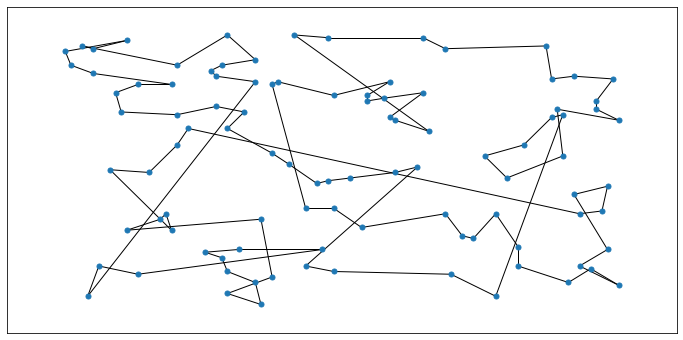

In [71]:
alns.draw_transition()
rc('animation', html='jshtml')
alns.anim

In [72]:
alns.anim.to_jshtml()

'\n<link rel="stylesheet"\nhref="https://maxcdn.bootstrapcdn.com/font-awesome/4.4.0/\ncss/font-awesome.min.css">\n<script language="javascript">\n  function isInternetExplorer() {\n    ua = navigator.userAgent;\n    /* MSIE used to detect old browsers and Trident used to newer ones*/\n    return ua.indexOf("MSIE ") > -1 || ua.indexOf("Trident/") > -1;\n  }\n\n  /* Define the Animation class */\n  function Animation(frames, img_id, slider_id, interval, loop_select_id){\n    this.img_id = img_id;\n    this.slider_id = slider_id;\n    this.loop_select_id = loop_select_id;\n    this.interval = interval;\n    this.current_frame = 0;\n    this.direction = 0;\n    this.timer = null;\n    this.frames = new Array(frames.length);\n\n    for (var i=0; i<frames.length; i++)\n    {\n     this.frames[i] = new Image();\n     this.frames[i].src = frames[i];\n    }\n    var slider = document.getElementById(this.slider_id);\n    slider.max = this.frames.length - 1;\n    if (isInternetExplorer()) {\n    

In [73]:
alns.anim.to_html5_video()

'<video width="864" height="432" controls autoplay loop>\n  <source type="video/mp4" src="data:video/mp4;base64,AAAAHGZ0eXBNNFYgAAACAGlzb21pc28yYXZjMQAAAAhmcmVlAAD5SW1kYXQAAAKuBgX//6rcRem9\n5tlIt5Ys2CDZI+7veDI2NCAtIGNvcmUgMTUyIHIyODU0IGU5YTU5MDMgLSBILjI2NC9NUEVHLTQg\nQVZDIGNvZGVjIC0gQ29weWxlZnQgMjAwMy0yMDE3IC0gaHR0cDovL3d3dy52aWRlb2xhbi5vcmcv\neDI2NC5odG1sIC0gb3B0aW9uczogY2FiYWM9MSByZWY9MyBkZWJsb2NrPTE6MDowIGFuYWx5c2U9\nMHgzOjB4MTEzIG1lPWhleCBzdWJtZT03IHBzeT0xIHBzeV9yZD0xLjAwOjAuMDAgbWl4ZWRfcmVm\nPTEgbWVfcmFuZ2U9MTYgY2hyb21hX21lPTEgdHJlbGxpcz0xIDh4OGRjdD0xIGNxbT0wIGRlYWR6\nb25lPTIxLDExIGZhc3RfcHNraXA9MSBjaHJvbWFfcXBfb2Zmc2V0PS0yIHRocmVhZHM9MyBsb29r\nYWhlYWRfdGhyZWFkcz0xIHNsaWNlZF90aHJlYWRzPTAgbnI9MCBkZWNpbWF0ZT0xIGludGVybGFj\nZWQ9MCBibHVyYXlfY29tcGF0PTAgY29uc3RyYWluZWRfaW50cmE9MCBiZnJhbWVzPTMgYl9weXJh\nbWlkPTIgYl9hZGFwdD0xIGJfYmlhcz0wIGRpcmVjdD0xIHdlaWdodGI9MSBvcGVuX2dvcD0wIHdl\naWdodHA9MiBrZXlpbnQ9MjUwIGtleWludF9taW49MTAgc2NlbmVjdXQ9NDAgaW50cmFfcmVmcmVz\naD0wIHJjX2xvb2thaGVhZD00MCByYz

In [74]:
alns.anim.save(f'{data_name}.mp4')

Best heuristic objective is 808.


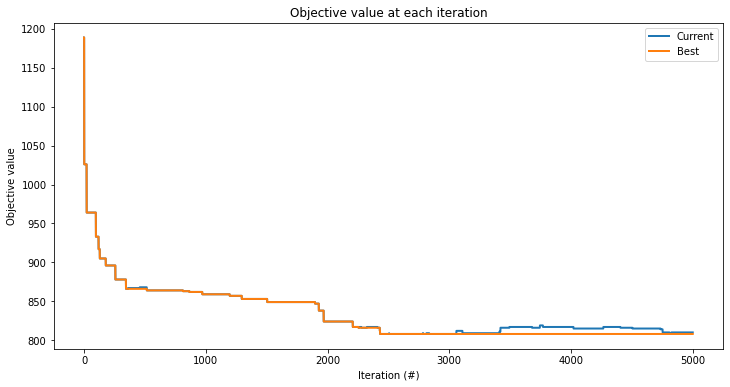

In [75]:
print(f'Best heuristic objective is {objective}.')

_, ax = plt.subplots(figsize=(12, 6))
result.plot_objectives(ax=ax, lw=2)

Having obtained a reasonable solution, we now want to investigate each operator's performance. This may be done via the `plot_operator_counts()` method on the `result` object, like below. 

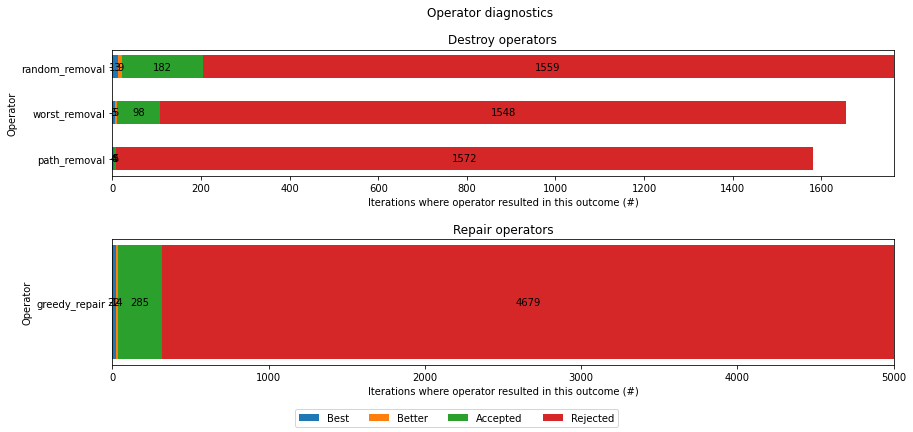

In [76]:
figure = plt.figure("operator_counts", figsize=(14, 6))
figure.subplots_adjust(bottom=0.15, hspace=.5)
result.plot_operator_counts(figure=figure, title="Operator diagnostics")

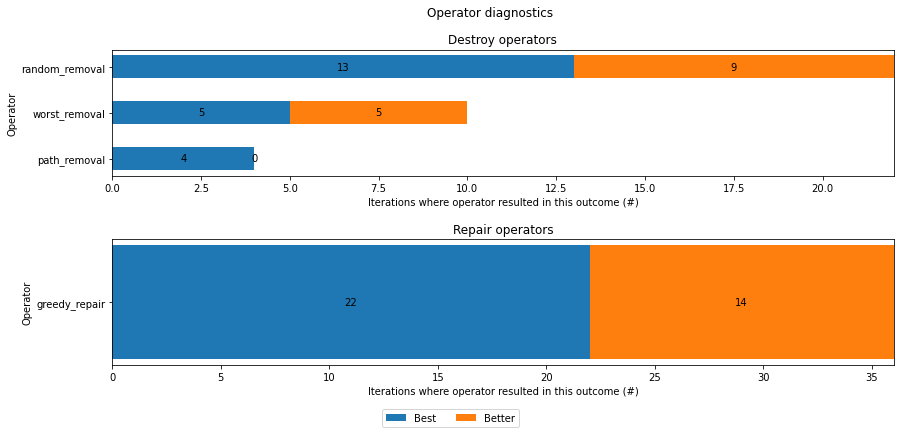

In [77]:
figure = plt.figure("operator_counts", figsize=(14, 6))
figure.subplots_adjust(bottom=0.15, hspace=.5)
result.plot_operator_counts(figure=figure, title="Operator diagnostics", legend=["Best", "Better"])

Several conclusions follow.

* Of the destroy operators, `random_removal` and `path_removal` perform similarly: while `random_removal` results in more accepted solution states, both find globally best states at about the same rate. Observe that `worst_removal` does not actually result in many better or equivalent states, which suggests it is inferior to the other two destroy operators. 
* The `greedy_repair` repair heuristic leads to many solution states that are inferior to the current best state, and are thus rejected by the ALNS algorithm. This is unfortunate, and suggests a better repair heuristic should be found. Ideally, such a heuristic would better exploit the problem structure.

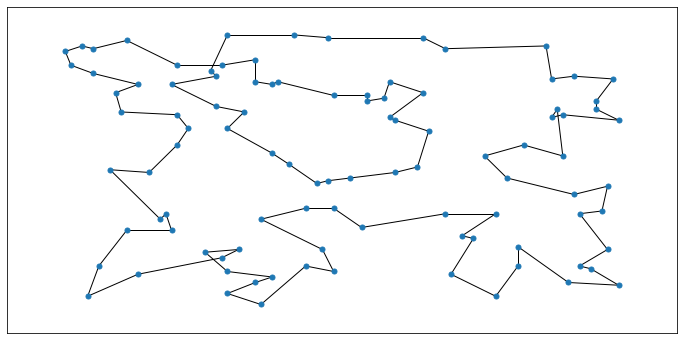

In [78]:
draw_graph(solution.to_graph())

In [79]:
before, after = initial_solution.objective(), solution.objective()
print('{0:.2f}% improvement.'.format((before - after) / before * 100))

32.04% improvement.


## Post-processing

It is not difficult to see the above solution can easily be improved upon: there are plenty of inefficiencies in small subpaths near both the center and the various corners of the tour. We will partially remedy this with a single pass over all nodes, optimally choosing a subpath of length ``k`` starting at each of these nodes. Since such a process is computationally demanding, we select ``k = 7``.

In [80]:
k = 7

In [81]:
def fix_bounds(permutation, start_node, end_node):
    """
    Fixes the given permutation to the start and end nodes, such that
    it connects up to the remainder of the solution.
    """
    return (start_node,) + permutation + (end_node,)

In [82]:
def optimal_subpath(nodes, start_node, end_node):
    """
    Computes the minimum cost subpath from the given nodes, where the 
    subpath is fixed at start_node and end_node.
    """
    def cost(subpath):
        path = fix_bounds(subpath, start_node, end_node)
        
        return sum(distances.euclidean(path[idx][1], path[idx + 1][1])
                   for idx in range(len(path) - 1))

    subpath = min(itertools.permutations(nodes, k), key=cost)

    return fix_bounds(subpath, start_node, end_node)

In [83]:
def post_process(state):
    """
    For each node in the passed-in state, this post processing step 
    computes the optimal subpath consisting of the next k nodes. This
    results in a run-time complexity of about O(n * k!), where n is
    the number of nodes.
    """
    state = state.copy()

    for start_node in state.nodes:
        nodes = []
        node = start_node

        # Determine the next k nodes that make up the subpath starting
        # at this start_node.
        for _ in range(k):
            node = state.edges[node]
            nodes.append(node)
        
        end_node = state.edges[node]

        optimal = optimal_subpath(nodes, start_node, end_node)
        
        # Replace the existing path with the optimal subpath.
        for first, second in zip(optimal, optimal[1:]):
            state.edges[first] = second

    return state

In [84]:
new_solution = post_process(solution)
new_objective = new_solution.objective()

print(f"New heuristic objective is {new_objective}.")

New heuristic objective is 783.


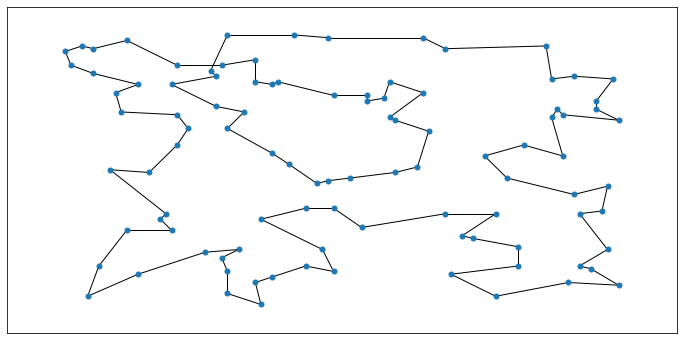

In [85]:
draw_graph(new_solution.to_graph())

# Conclusions

In the code above we implemented a very simple heuristic for the TSP, using the ALNS meta-heuristic framework. We did not tinker too much with the various hyperparameters available on the ALNS implementation, but even for these relatively basic heuristic methods and workflow we find a very good result - just 2.1% worse than the optimal tour.

This notebook showcases how the ALNS library may be put to use to construct powerful, efficient heuristic pipelines from simple, locally greedy operators.

In [86]:
before, after = initial_solution.objective(), new_solution.objective()
print('{0:.2f}% improvement.'.format((before - after) / before * 100))

34.15% improvement.
